In [1]:
## "pycxsimulator.py"
## Realtime Simulation GUI for PyCX
##
## Developed by:
## Chun Wong
## email@chunwong.net
##
## Revised by:
## Hiroki Sayama
## sayama@binghamton.edu
##
## Copyright 2012 Chun Wong & Hiroki Sayama
##
## Simulation control & GUI extensions
## Copyright 2013 Przemyslaw Szufel & Bogumil Kaminski
## {pszufe, bkamins}@sgh.waw.pl
##
## Fixing errors due to "the grid and pack problem" by:
## Toshihiro Tanizawa
## tanizawa@ee.kochi-ct.ac.jp
## began at 2016-06-15(Wed) 17:10:17
## fixed grid() and pack() problem on 2016-06-21(Tue) 18:29:40
##
## The following two lines should be placed at the beginning of your simulator code:
##
## import matplotlib
## matplotlib.use('TkAgg')

import pylab as PL
from tkinter import ttk
from tkinter import *
from tkinter.ttk import Notebook


class GUI:

    ## GUI variables
    titleText = 'PyCX Simulator'  # window title
    timeInterval = 0              # refresh time in milliseconds
    running = False
    modelFigure = None
    stepSize = 1
    currentStep = 0
    
    # Constructor
    def __init__(self, title='PyCX Simulator', interval=0, stepSize=1, parameterSetters=[]):
        self.titleText = title
        self.timeInterval = interval
        self.stepSize = stepSize
        self.parameterSetters = parameterSetters
        self.varEntries = {}
        self.statusStr = ""
               
        self.initGUI()
        
        
    # Initialization
    def initGUI(self):
        
        #create root window
        self.rootWindow = Tk()
        self.statusText = StringVar(value=self.statusStr) # at this point, statusStr = ""
        self.setStatusStr("Simulation not yet started")

        self.rootWindow.wm_title(self.titleText) # titleText = 'PyCX Simulator'
        self.rootWindow.protocol('WM_DELETE_WINDOW', self.quitGUI)
        self.rootWindow.geometry('450x300')
        self.rootWindow.columnconfigure(0, weight=1)
        self.rootWindow.rowconfigure(0, weight=1)
        
        self.notebook = Notebook(self.rootWindow)      
        self.notebook.pack(side=TOP, padx=2, pady=2)
        
        self.frameRun = Frame()
        self.frameSettings = Frame()
        self.frameParameters = Frame()
        self.frameInformation = Frame()          
        
        self.notebook.add(self.frameRun,text="Run")
        self.notebook.add(self.frameSettings,text="Settings")
        self.notebook.add(self.frameParameters,text="Parameters")
        self.notebook.add(self.frameInformation,text="Info")
        self.notebook.pack(expand=NO, fill=BOTH, padx=5, pady=5 ,side=TOP)
        
        self.status = Label(self.rootWindow, width=40,height=3, relief=SUNKEN, bd=1, textvariable=self.statusText)
        self.status.pack(side=TOP, fill=X, padx=5, pady=5, expand=NO)

        # -----------------------------------
        # frameRun
        # -----------------------------------
        # buttonRun
        self.runPauseString = StringVar()
        self.runPauseString.set("Run")
        self.buttonRun = Button(self.frameRun,width=30,height=2,textvariable=self.runPauseString,command=self.runEvent)
        self.buttonRun.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonRun,"Runs the simulation (or pauses the running simulation)")
        
        # buttonStep
        self.buttonStep = Button(self.frameRun,width=30,height=2,text='Step Once',command=self.stepOnce)
        self.buttonStep.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonStep,"Steps the simulation only once")
        
        # buttonReset
        self.buttonReset = Button(self.frameRun,width=30,height=2,text='Reset',command=self.resetModel)
        self.buttonReset.pack(side=TOP, padx=5, pady=5) 
        self.showHelp(self.buttonReset,"Resets the simulation")

        # -----------------------------------
        # frameSettings
        # -----------------------------------
        can = Canvas(self.frameSettings)
        
        lab = Label(can, width=25,height=1,text="Step size ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        
        self.stepScale = Scale(can,from_=1, to=50, resolution=1,
                               command=self.changeStepSize,orient=HORIZONTAL, width=25,length=150)
        self.stepScale.set(self.stepSize)
        self.showHelp(self.stepScale,"Skips model redraw during every [n] simulation steps \
                      \nResults in a faster model run.")
        self.stepScale.pack(side='left')
        
        can.pack(side='top')
    
        can = Canvas(self.frameSettings)
        lab = Label(can, width=25,height=1,text="Step visualization delay in ms ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        self.stepDelay = Scale(can,from_=0, to=max(2000,self.timeInterval),
                               resolution=10,command=self.changeStepDelay,orient=HORIZONTAL, width=25,length=150)
        self.stepDelay.set(self.timeInterval)
        self.showHelp(self.stepDelay,"The visualization of each step is delays by the given number of milliseconds.")
        self.stepDelay.pack(side='left')
        
        can.pack(side='top')
        
        # --------------------------------------------
        # frameInformation
        # --------------------------------------------
        scrollInfo = Scrollbar(self.frameInformation)
        self.textInformation = Text(self.frameInformation, width=45,
                                    height=13,bg='lightgray',wrap=WORD,font=("Courier",10))
        scrollInfo.pack(side=RIGHT, fill=Y)
        self.textInformation.pack(side=LEFT,fill=BOTH,expand=YES)
        scrollInfo.config(command=self.textInformation.yview)
        self.textInformation.config(yscrollcommand=scrollInfo.set)
        
        # --------------------------------------------
        # ParameterSetters
        # --------------------------------------------
        for variableSetter in self.parameterSetters:
            can = Canvas(self.frameParameters)
            
            lab = Label(can, width=25,height=1,text=variableSetter.__name__+" ",anchor=W,takefocus=0)
            lab.pack(side='left')
            
            ent = Entry(can, width=11)
            ent.insert(0, str(variableSetter()))
            
            if variableSetter.__doc__ != None and len(variableSetter.__doc__) > 0:
                self.showHelp(ent,variableSetter.__doc__.strip())
                
            ent.pack(side='left')
                
            can.pack(side='top')
            
            self.varEntries[variableSetter]=ent
            
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters = Button(self.frameParameters,width=50,height=1,
                                               command=self.saveParametersCmd,
                                               text="Save parameters to the running model",state=DISABLED)
            self.showHelp(self.buttonSaveParameters,
                          "Saves the parameter values. \
                          \nNot all values may take effect on a running model \
                          \nA model reset might be required.")
            self.buttonSaveParameters.pack(side='top',padx=5,pady=5)
            self.buttonSaveParametersAndReset = Button(self.frameParameters,width=50,height=1,
                                                       command=self.saveParametersAndResetCmd,
                                                       text="Save parameters to the model and reset the model")
            self.showHelp(self.buttonSaveParametersAndReset,"Saves the given parameter values and resets the model")
            self.buttonSaveParametersAndReset.pack(side='top',padx=5,pady=5)
    # <<<<< Init >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    def setStatusStr(self,newStatus):
        self.statusStr = newStatus
        self.statusText.set(self.statusStr)
        
        
    # model control functions for changing parameters
    def changeStepSize(self,val):        
        self.stepSize = int(val)
        
    def changeStepDelay(self,val):        
        self.timeInterval= int(val)
        
    def saveParametersCmd(self):
        for variableSetter in self.parameterSetters:
            variableSetter(float(self.varEntries[variableSetter].get()))
            self.setStatusStr("New parameter values have been set")
            
    def saveParametersAndResetCmd(self):
        self.saveParametersCmd()
        self.resetModel()

        
    # <<<< runEvent >>>>>
    # This event is envoked when "Run" button is clicked.
    def runEvent(self):
        self.running = not self.running
        if self.running:
            self.rootWindow.after(self.timeInterval,self.stepModel)
            self.runPauseString.set("Pause")
            self.buttonStep.configure(state=DISABLED)
            self.buttonReset.configure(state=DISABLED)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=DISABLED)     
        else:
            self.runPauseString.set("Continue Run")
            self.buttonStep.configure(state=NORMAL)
            self.buttonReset.configure(state=NORMAL)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=NORMAL)

    def stepModel(self):
        if self.running:
            self.modelStepFunc()
            self.currentStep += 1
            self.setStatusStr("Step "+str(self.currentStep))
            self.status.configure(foreground='black')
            if (self.currentStep) % self.stepSize == 0:
                self.drawModel()
            self.rootWindow.after(int(self.timeInterval*1.0/self.stepSize),self.stepModel)

    def stepOnce(self):
        self.running = False
        self.runPauseString.set("Continue Run")
        self.modelStepFunc()
        self.currentStep += 1
        self.setStatusStr("Step "+str(self.currentStep))
        self.drawModel()
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters.configure(state=NORMAL)

    def resetModel(self):
        self.running = False        
        self.runPauseString.set("Run")
        self.modelInitFunc()
        self.currentStep = 0;
        self.setStatusStr("Model has been reset")
        self.drawModel()

    def drawModel(self):
        PL.ion() # bug fix by Alex Hill in 2013
        if self.modelFigure == None or self.modelFigure.canvas.manager.window == None:
            self.modelFigure = PL.figure()
        self.modelDrawFunc()
        self.modelFigure.canvas.manager.window.update()
        PL.show() # bug fix by Hiroki Sayama in 2016

    def start(self,func=[]):
        if len(func)==3:
            self.modelInitFunc = func[0]
            self.modelDrawFunc = func[1]
            self.modelStepFunc = func[2]            
            if (self.modelStepFunc.__doc__ != None and len(self.modelStepFunc.__doc__)>0):
                self.showHelp(self.buttonStep,self.modelStepFunc.__doc__.strip())                
            if (self.modelInitFunc.__doc__ != None and len(self.modelInitFunc.__doc__)>0):
                self.textInformation.config(state=NORMAL)
                self.textInformation.delete(1.0, END)
                self.textInformation.insert(END, self.modelInitFunc.__doc__.strip())
                self.textInformation.config(state=DISABLED)
                
            self.modelInitFunc()
            self.drawModel()     
        self.rootWindow.mainloop()

    def quitGUI(self):
        PL.close('all')
        self.rootWindow.quit()
        self.rootWindow.destroy()
    
    def showHelp(self, widget,text):
        def setText(self):
            self.statusText.set(text)
            self.status.configure(foreground='blue')
            
        def showHelpLeave(self):
            self.statusText.set(self.statusStr)
            self.status.configure(foreground='black')
        widget.bind("<Enter>", lambda e : setText(self))
        widget.bind("<Leave>", lambda e : showHelpLeave(self))

In [57]:
import matplotlib as plt
%matplotlib inline
from pylab import *

def initialize(n, p):
    global config, nextconfig, density
    config = zeros([n, n])
    density = []
    for x in range(n):
        for y in range(n):
            config[x, y] = 1 if random() < p else 0
    nextconfig = zeros([n, n])
    
def observe():
    global config, nextconfig
    cla()
    pl.subplot(1,2,1)
    imshow(config, vmin = 0, vmax = 1, cmap = cm.binary)
    pl.subplot(1,2,2)
    plt.plot(density)
    plt.show()

def update(n):
    global config, nextconfig, density
    for x in range(n):
        for y in range(n):
            count = 0
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    count += config[(x + dx) % n, (y + dy) % n]
            nextconfig[x, y] = 1 if count >= 4 else 0
    density.append(np.mean(config.ravel()))
    config, nextconfig = nextconfig, config

## Sayama, Exercise 11.5
Implement an interactive parameter setter for p in Code 11.5. Then conduct systematic simulations with varying p, and identify its critical value below which isolated clusters are formed but above which the whole space is filled with panic.
Experiment with initial density parameter in the Panic CA. Also answer the following question: Around which value of the initial density parameter does the phase transition (the whole space getting filled with panic) happen?

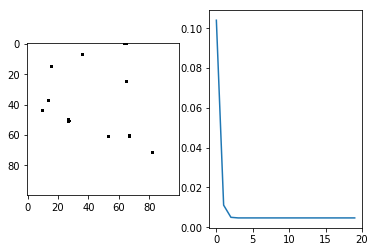

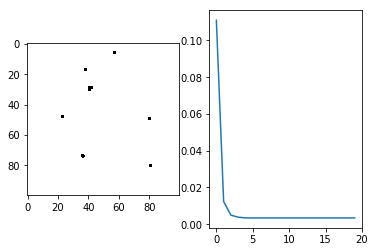

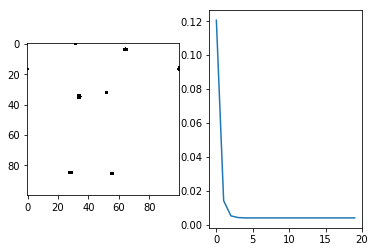

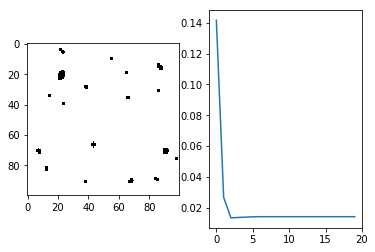

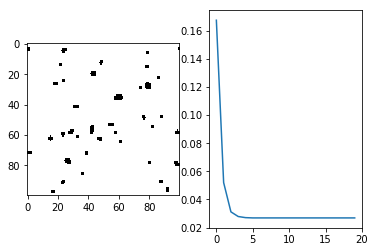

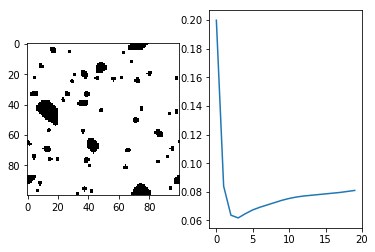

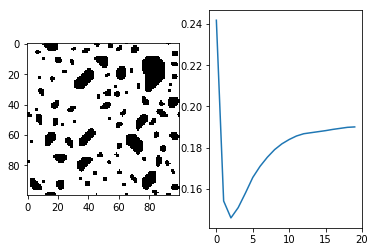

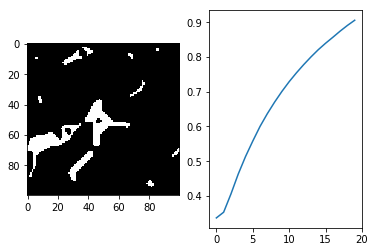

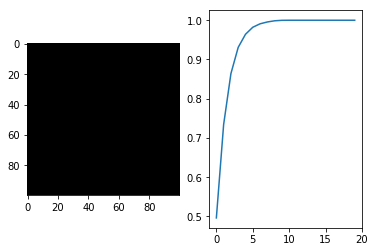

In [59]:
for i in range(10, 1, -1):
    N = 100
    pro = 1/i
    initialize(N, pro)
    for _ in range(20):
        update(N)
    observe()

## Sayama, Exercise 11.3
Modify Code 11.5 to implement a simulator of the Game of Life CA. Simulate the dynamics from a random initial configuration. Measure the density of state 1’s in the configuration at each time step, and plot how the density changes over time. This can be done by creating an empty list in the initialize function, and then making the measurement and appending the result to the list in the observe function. The results stored in the list can be plotted manually after the
simulation, or they could be plotted next to the visualization using pylab’s subplot function during the simulation.

In [72]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl

def initialize():
    global config, nextconfig, density
    density = []
    config = pl.zeros([n, n])
    for x in range(n):
        for y in range(n):
            config[x, y] = 1 if pl.random() < p else 0
            nextconfig = pl.zeros([n, n])
            
def observe():
    global config, nextconfig
    pl.cla()
    pl.imshow(config, vmin = 0, vmax = 1, cmap = pl.cm.binary)
    pl.show()
    pl.plot(density)
    pl.title('Density')
    pl.show()

def update():
    global config, nextconfig, density
    for x in range(n):
        for y in range(n):
            count = 0
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    count += config[(x + dx) % n, (y + dy) % n]
            """
            Any live cell with fewer than two live neighbours dies, as if by underpopulation.
            Any live cell with two or three live neighbours lives on to the next generation.
            Any live cell with more than three live neighbours dies, as if by overpopulation.
            Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.
            """
            if config[x, y] == 0:
                nextconfig[x, y] = 1 if count == 3 else 0
            if config[x, y] == 1:
                nextconfig[x, y] = 1 if (count == 3) or (count == 2) else 0
    
    density.append(np.mean(config.ravel()))
    config, nextconfig = nextconfig, config

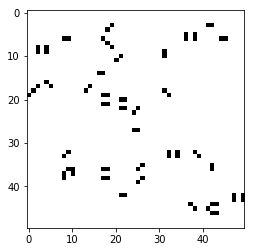

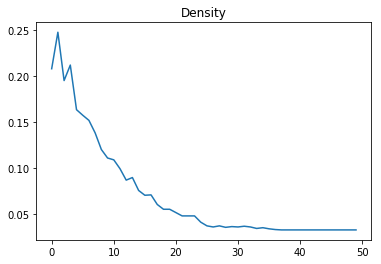

In [73]:
initialize()
for i in range(50):
    update()
observe()